<a href="https://colab.research.google.com/github/1000century/likelion_proj2/blob/main/train/code/v11_occ_vet_q_sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install evaluate -qq
! pip install datasets -qq
! pip install bert_score -qq
! pip install rouge-score -qq
! pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [ ]:
import gc

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import json
import os
import zipfile
from typing import List, Dict

def flatten_json_data(data_list):
    """JSON 데이터를 평탄화하는 함수"""
    return pd.json_normalize(
        data_list,
        sep='_',
        record_path=None,
        meta=[
            'category',
            'job_field',
            'gender',
            'experience',
            ['version'],
            ['dataSet', 'answer', 'raw', 'text'],
            ['dataSet', 'answer', 'summary', 'text'],
            ['dataSet', 'question', 'raw', 'text'],
            ['dataSet', 'info', 'ageRange'],
            ['dataSet', 'info', 'channel'],
            ['dataSet', 'info', 'date'],
            ['dataSet', 'info', 'experience'],
            ['dataSet', 'info', 'gender'],
            ['dataSet', 'info', 'occupation'],
            ['dataSet', 'info', 'place'],
            ['rawDataInfo', 'answer', 'audioPath'],
            ['rawDataInfo', 'question', 'audioPath']
        ]
    )

def download_and_extract(urls: List[str], base_path: str) -> None:
    """
    URL 리스트에서 ZIP 파일을 다운로드하고 압축을 해제하는 함수
    """
    os.makedirs(base_path, exist_ok=True)

    for i, url in enumerate(urls):
        zip_file_name = url.split("/")[-1]
        zip_file_path = os.path.join("/kaggle/working", zip_file_name)
        print(f'처리중... {i+1}: {zip_file_name}')

        # wget을 사용하여 파일 다운로드
        !wget -q {url} -O {zip_file_path}

        # 압축 해제할 폴더 생성
        subfolder_name = zip_file_name.replace('.zip', '')
        subfolder_path = os.path.join(base_path, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # ZIP 파일 압축 해제
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(subfolder_path)

        # 다운로드한 ZIP 파일 삭제
        os.remove(zip_file_path)

def create_dataset_from_json_files(base_path: str) -> Dataset:
    """
    주어진 경로에서 JSON 파일들을 읽어 Dataset으로 변환하는 함수
    """
    all_data = []

    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # 파일 경로에서 메타데이터 추출
                        folder_name = os.path.basename(os.path.dirname(file_path))
                        parts = folder_name.split('_')
                        data.update({
                            'category': parts[0],  # TL or VL
                            'job_field': '_'.join(parts[1:-2]),
                            'gender': parts[-2],
                            'experience': parts[-1]
                        })
                        all_data.append(data)
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")

    # JSON 데이터 평탄화
    df = flatten_json_data(all_data)

    # DataFrame을 Dataset으로 변환
    return Dataset.from_pandas(df)

def create_interview_dataset():
    """
    인터뷰 데이터셋을 생성하고 DatasetDict로 반환하는 함수
    """
    # 훈련 데이터 URL
    train_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Training/TL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 검증 데이터 URL
    valid_urls = [
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_01.Management_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_02.SalesMarketing_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_03.PublicService_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_04.RND_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_05.ICT_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_06.Design_Male_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Female_New.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_Experienced.zip",
        "https://github.com/1000century/multi_lion/raw/main/interview/Validation/VL_07.ProductionManufacturing_Male_New.zip"
    ]

    # 데이터 다운로드 및 압축 해제
    train_path = '/kaggle/working/train_unzipped'
    valid_path = '/kaggle/working/validation_unzipped'

    download_and_extract(train_urls, train_path)
    download_and_extract(valid_urls, valid_path)

    # 데이터셋 생성
    train_dataset = create_dataset_from_json_files(train_path)
    valid_dataset = create_dataset_from_json_files(valid_path)

    # DatasetDict 생성
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': valid_dataset
    })

    return dataset_dict

In [ ]:
# 데이터셋 생성
dataset = create_interview_dataset()

# 데이터셋 정보 출력
print("\nDataset Info:")
print(dataset)

# 훈련 데이터 샘플 확인
print("\nTraining Data Sample:")
print(dataset['train'][0])

# 검증 데이터 샘플 확인
print("\nValidation Data Sample:")
print(dataset['validation'][0])

# 데이터셋을 로컬이나 HuggingFace Hub에 저장하기
# dataset.save_to_disk("path/to/local/directory")  # 로컬에 저장
# dataset.push_to_hub("username/dataset-name")     # HuggingFace Hub에 업로드

처리중... 1: TL_01.Management_Female_Experienced.zip
처리중... 2: TL_01.Management_Female_New.zip
처리중... 3: TL_01.Management_Male_Experienced.zip
처리중... 4: TL_01.Management_Male_New.zip
처리중... 5: TL_02.SalesMarketing_Female_Experienced.zip
처리중... 6: TL_02.SalesMarketing_Female_New.zip
처리중... 7: TL_02.SalesMarketing_Male_Experienced.zip
처리중... 8: TL_02.SalesMarketing_Male_New.zip
처리중... 9: TL_03.PublicService_Female_Experienced.zip
처리중... 10: TL_03.PublicService_Female_New.zip
처리중... 11: TL_03.PublicService_Male_Experienced.zip
처리중... 12: TL_03.PublicService_Male_New.zip
처리중... 13: TL_04.RND_Female_Experienced.zip
처리중... 14: TL_04.RND_Female_New.zip
처리중... 15: TL_04.RND_Male_Experienced.zip
처리중... 16: TL_04.RND_Male_New.zip
처리중... 17: TL_05.ICT_Female_Experienced.zip
처리중... 18: TL_05.ICT_Female_New.zip
처리중... 19: TL_05.ICT_Male_Experienced.zip
처리중... 20: TL_05.ICT_Male_New.zip
처리중... 21: TL_06.Design_Female_Experienced.zip
처리중... 22: TL_06.Design_Female_New.zip
처리중... 23: TL_06.Design_Male_Ex

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
import numpy as np

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "skt/kogpt2-base-v2",
    bos_token='</s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dataset['train'][0]

{'version': '1.0',
 'category': 'TL',
 'job_field': '02.SalesMarketing',
 'gender': 'Female',
 'experience': 'New',
 'dataSet_info_date': '20230116',
 'dataSet_info_occupation': 'SM',
 'dataSet_info_channel': 'MOCK',
 'dataSet_info_place': 'ONLINE',
 'dataSet_info_gender': 'FEMALE',
 'dataSet_info_ageRange': '45-54',
 'dataSet_info_experience': 'NEW',
 'dataSet_question_raw_text': '지원자님께서 대학 생활을 보내면서 가장 힘들었던 경험은 무엇이었습니까 그리고 지원자님께서는 그것을 어떻게 극복했는지도 말해 주시기 바랍니다',
 'dataSet_question_raw_wordCount': 16,
 'dataSet_question_emotion': [],
 'dataSet_question_intent': [],
 'dataSet_answer_raw_text': '대학 생활에서 가장 힘들었던 경험은 어 제가 언어를 전공했는데요. 그 외국어를 전공하다 보니 어 그것을 말하는 사람들과 직접적으로 소통하고 어 어 그 배워야 하는데 그런 기회가 좀 적었어요. 어 경제적 여유가 없었기 때문에 어 그 사람들에게 어 음 그 가르침을 받을 기회를 갖지 못했구요. 또 그 그 당시에는 사실 외국인들이 서울을 제외하고는 어 지방에 많이 거주하지도 않았어요. 그래서 제가 한 방법은 어 그 외국에서 온 선교사들 어 그 선교사들을 어 개인적으로 좀 그 친숙한 관계를 유지해서 그들에게서 어 영어를 좀 배웠어요. 어 어떤 의미에서는 제가 그들을 이용했다는 느낌이 드는데요. 어 종교적으로 동화되지 않고 그 영어만을 배울고자 하는 어 그 열망을 분명히 그들에게 전했고요. 그들 또한 그 사실을 알면서도 

In [ ]:
# 직무 코드를 실제 직무명으로 변환하는 딕셔너리
occupation_map = {
    'SM': '영업마케팅',
    'PS': '공공서비스',
    'RND': '연구개발',
    'ICT': '정보통신',
    'ARD': '디자인',
    'MM': '생산관리',
    'BM': '경영사무'
}



In [ ]:
def preprocess_training_examples(examples):
    max_length=256
    formatted_inputs = [
        f"</s> 직무: {occupation_map[occ]} 경력상태: {'신입' if exp == 'NEW' else '경력직'} 질문: {q} 답변: {a} </s>"
        for occ, exp, q, a in zip(
            examples["dataSet_info_occupation"],
            examples["dataSet_info_experience"],
            examples["dataSet_question_raw_text"],
            examples["dataSet_answer_summary_text"]
        )
    ]
    inputs = tokenizer(
        formatted_inputs,
        max_length=max_length,
        truncation= True,
        padding="max_length",
        return_tensors="pt"
    )

    labels = inputs['input_ids'].clone()
    labels[labels==tokenizer.pad_token_id] = -100
    inputs['labels'] = labels
    return inputs


train_dataset = dataset['train'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['train'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

val_dataset = dataset['validation'].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset['validation'].column_names,
    load_from_cache_file=False  # 이 옵션 추가
)

Map:   0%|          | 0/68074 [00:00<?, ? examples/s]

Map:   0%|          | 0/8026 [00:00<?, ? examples/s]

In [ ]:
print(len(train_dataset))
# # 코드 잘 돌아가는지 확인 위해 train_dataset 임의로 매우 적은 개수로 샘플링
# from torch.utils.data import Subset
# train_dataset = Subset(train_dataset, indices=range(40))
# val_dataset = Subset(val_dataset, indices=range(80))
print(len(train_dataset))
print(len(val_dataset))

68074
68074
8026


# Model

In [ ]:
import torch
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
import psutil
import os

def log_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Current memory usage: {process.memory_info().rss / 1e6} MB")


In [ ]:
from transformers import Trainer
import evaluate

In [ ]:
import evaluate
import numpy as np
import torch
from rouge_score import rouge_scorer
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')
bleu = evaluate.load('bleu')

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Predictions 튜플 처리
    print("\n", '='*50,"\nPredictions type:", type(predictions))
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Predictions와 Labels를 numpy 배열로 변환
    if isinstance(predictions, torch.Tensor):
        print("Converting Predictions to numpy...")
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        print("Converting Labels to numpy...")
        labels = labels.cpu().numpy()

    # Decode predictions and labels
    print("Decoding predictions and labels...")
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=False)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)

    # Post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    print("Decoded Predictions Sample:\n", decoded_preds[:3])
    print("Decoded Labels Sample:\n", decoded_labels[:3])

    # Calculate ROUGE metrics using rouge-score
    print("Calculating ROUGE...")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for pred, label in zip(decoded_preds, decoded_labels):
        if pred and label:  # 둘 다 비어있지 않은 경우만 계산
            scores = scorer.score(label, pred)
            rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    print("\nROUGE scores details:")
    print(f"Number of valid pairs: {len(rouge_scores['rouge1'])}")
    if rouge_scores['rouge1']:
        print(f"Sample ROUGE-1 scores: {rouge_scores['rouge1'][:5]}")

    rouge_result = {
        'rouge1': np.mean(rouge_scores['rouge1']) * 100 if rouge_scores['rouge1'] else 0,
        'rouge2': np.mean(rouge_scores['rouge2']) * 100 if rouge_scores['rouge2'] else 0,
        'rougeL': np.mean(rouge_scores['rougeL']) * 100 if rouge_scores['rougeL'] else 0
    }

    # Calculate other metrics
    print("Calculating METEOR...")
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    print("METEOR result:", meteor_result)

    print("Calculating BERTScore...")
    bertscore_result = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="ko", device='cuda' if torch.cuda.is_available() else 'cpu')
    print("BERTScore finished")

    print("Calculating BLEU...")
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    print("BLEU result:", bleu_result)

    # Combine results
    result = {
        **rouge_result,
        "meteor": round(meteor_result["meteor"] * 100, 4),
        "bertscore_f1": round(np.mean(bertscore_result["f1"]) * 100, 4),
        "bleu": round(bleu_result["bleu"] * 100, 4)
    }

    print("Calculating generated length...")
    result['gen_len'] = np.mean([len(pred.split()) for pred in decoded_preds])
    print("Final Metrics:", result)

    return result

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
from transformers import Trainer, TrainingArguments

# Training arguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # 모델이 저장될 경로
    evaluation_strategy="epoch",    # 매 에포크마다 평가
    save_strategy="epoch",          # 매 에포크마다 저장
    learning_rate=5e-5,             # 기본 학습률
    per_device_train_batch_size=16,  # 각 디바이스에서의 배치 사이즈
    per_device_eval_batch_size=32,   # 평가 시의 배치 사이즈
    eval_accumulation_steps=8,      # 평가 시 gradient accumulation steps
    num_train_epochs=6,             # 에포크 수
    weight_decay=0.01,              # 가중치 감쇠
    save_total_limit=2,             # 저장할 체크포인트 개수 제한
    logging_dir='./logs',           # 로깅 파일 저장 위치
    logging_steps=500,              # 로깅 빈도
    load_best_model_at_end=True,    # 가장 좋은 모델을 끝에서 로드
    eval_steps=1000,                # 평가 빈도
    fp16=True,                      # Mixed Precision (FP16) 사용
    dataloader_num_workers=4,       # DataLoader에서 사용할 워커 수
    deepspeed=None,                 # DeepSpeed는 사용하지 않음
    report_to="none",               # 로깅 서비스 (TensorBoard 등 사용하지 않음)
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
)

# DataLoader 확인 및 메모리 상태 출력
print(f"Total train batches: {len(trainer.get_train_dataloader())}")
print(f"Total eval batches: {len(trainer.get_eval_dataloader())}")
print(f"Batch size train: {training_args.per_device_train_batch_size}")
print(f"Batch size eval: {training_args.per_device_eval_batch_size}")
print(f"Eval accumulation steps: {training_args.eval_accumulation_steps}")

Total train batches: 2128
Total eval batches: 126
Batch size train: 16
Batch size eval: 32
Eval accumulation steps: 8


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
import warnings
import os

# fork 관련 경고 제거
warnings.filterwarnings('ignore', message="os.fork()")

# tokenizer 경고 제거
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# autocast 경고 제거
warnings.filterwarnings('ignore', message="`torch.cuda.amp.autocast")

# gather 경고 제거
warnings.filterwarnings('ignore', message="Was asked to gather along dimension 0")

In [ ]:
# 학습 시작
trainer.train()


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Meteor,Bertscore F1,Bleu,Gen Len
1,2.360200,2.632428,1.183579,0.009760,1.183579,4.785800,64.123200,0.183800,100.973461
2,2.191800,2.578747,1.183394,0.009700,1.183394,4.853100,63.647800,0.307700,116.595564
3,2.081300,2.570018,1.183208,0.009505,1.183208,4.913200,64.748000,0.069400,79.803514
4,1.970700,2.559250,1.182955,0.009374,1.182955,4.956000,64.948800,0.057600,76.885996
5,1.904200,2.567800,1.181456,0.009371,1.181456,4.963200,65.104300,0.037400,70.689011
6,1.835900,2.572062,1.182884,0.009527,1.182884,4.978500,65.067000,0.039500,71.301022



Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['직무: 경영 경력상태: 신입직 질문: 지원 지원께을 때 지원 고령 사람들이들이 아이 아이를 해외폰을 선호하는 경향이 많 것 같습니다 그렇다면 생각하는봤을 때 아이 그 층 아이폰을 선호하는하는지 그 말씀 생각을 말씀 싶데요 답드리립니다 답변: 젊은폰은 젊은 접을 접 할 그의 선도로 왔기 점에서 아이자들에게 많은성이 있고 그래서 점에서 아이폰을 선호하는으로는야 위해서는 젊은화 아이 아이자들이 어떤필할 것들이 가장 그리고해야 보고 싶치 해야 것이 중요합니다. </s>', '직무: 경영 경력상태: 신입직 질문: 지원 제외하고 살에 활용할 수 있을까요변: 저 전공은 경영입니다. 전공학을 제가 높이기하고 그에 있어 많은 할이 하는습니다. 그래서</s>                                                                                                                     전공     전공                     전공    전공', '직무: 경영 경력상태: 신입직 질문: 지원 소통롤 작든를 받는데다 지원 스트레스를 때 어떻게 혼자 스트레스 스트레스 스트레스법이 말씀 말씀 계 것이 있나 답변: 저를법은 혼자를에서 주변 큰 스트레스 스트레스 그 형태로 스트레스 집중 타인에게 자신을 사람들에게 이야기를 영향을 주는 것을 해소 경험 것입니다. 가장 생각합니다. 그래서레스는 제가 조금씩 것이고라 그 그 속에서 스트레스 하면 대처해야가 더 생각 합니다. </s>     스트레스 스트레스  스트레스    스트레스 스트레스 스트레스 스트레스 스트레스 스트레스  스트레스 스트레스  스트레스 스트레스 스트레스 스트레스 스트레스 스트레스 스트레스 스트레스 스트레스  스트레스 스트레스 스트레스 스트레스 스트레스 스트레스

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore finished
Calculating BLEU...
BLEU result: {'bleu': 0.001838295155073424, 'precisions': [0.2695258745108043, 0.1478457599335281, 0.08878146923653564, 0.058710919175473934], 'brevity_penalty': 0.015312729341416769, 'length_ratio': 0.1930848285399879, 'translation_length': 893814, 'reference_length': 4629126}
Calculating generated length...
Final Metrics: {'rouge1': 1.183579463626756, 'rouge2': 0.00976013290403059, 'rougeL': 1.183579463626756, 'meteor': 4.7858, 'bertscore_f1': 64.1232, 'bleu': 0.1838, 'gen_len': 100.97346125093446}

Predictions type: <class 'tuple'>
Decoding predictions and labels...
Decoded Predictions Sample:
 ['직무: 경영 경력상태: 신입직 질문: 지원 지원께을 때 지원 고령 사람들이들이 아이 아이가 해외폰을 선호하는 경향이 있는데 것 같습니다 그렇다면 생각하는봤을 때 젊은 그렇게 층 아이폰을 선호하는하는지 그 말씀 생각을 말씀 싶데요 그드리립니다 답변: 젊은폰은 젊은 나온을 접 하게 그을 선도하게 왔기 점에서 가장자들에게 많은성이 있고 아이 점에서 아이폰을 선호하는으로는야 위해서는 젊은 아이 아이 아이자들이 어떤필할 것이 가장 그리고을 봐 싶치 해 것이 중요하다고합니다. </s>', '직무: 경영 경력상태: 신입직 질문: 지원 제외하고 선택에 활용할 수 있는지까요변: 저 전공은 컴퓨터입니다. 전공학을 제가 극대하기 그에 있어 가장 

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=12768, training_loss=2.0701396507129335, metrics={'train_runtime': 21875.2624, 'train_samples_per_second': 18.672, 'train_steps_per_second': 0.584, 'total_flos': 5.3361581359104e+16, 'train_loss': 2.0701396507129335, 'epoch': 6.0})

In [ ]:
import os
import shutil

# 모델 가중치와 설정 저장
trainer.save_model("./results/best_model")

# 학습 상태 저장
trainer.save_state()

In [ ]:
import torch

# GPU 상태 초기화 및 남은 메모리 확인
for i in range(torch.cuda.device_count()):
    device = torch.device(f"cuda:{i}")

    # 메모리 초기화
    torch.cuda.empty_cache()  # GPU 캐시 비우기
    torch.cuda.ipc_collect()  # GPU 메모리에서 누수된 객체 수집

    # 메모리 통계 초기화
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)

    # GPU 메모리 상태 확인
    total_memory = torch.cuda.get_device_properties(device).total_memory  # 전체 메모리
    reserved_memory = torch.cuda.memory_reserved(device)  # 예약된 메모리
    allocated_memory = torch.cuda.memory_allocated(device)  # 사용 중인 메모리
    free_memory = reserved_memory - allocated_memory  # 예약된 메모리 중 사용 가능 메모리

    print(f"GPU {i} 메모리 리셋 완료!")
    print(f"  전체 메모리: {total_memory / 1024 ** 2:.2f} MB")
    print(f"  예약된 메모리: {reserved_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 중인 메모리: {allocated_memory / 1024 ** 2:.2f} MB")
    print(f"  사용 가능 메모리: {free_memory / 1024 ** 2:.2f} MB")


GPU 0 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 4028.00 MB
  사용 중인 메모리: 2102.13 MB
  사용 가능 메모리: 1925.87 MB
GPU 1 메모리 리셋 완료!
  전체 메모리: 15095.06 MB
  예약된 메모리: 32.00 MB
  사용 중인 메모리: 16.25 MB
  사용 가능 메모리: 15.75 MB


/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="본인의 강점이 무엇이라고 생각하시나요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,            # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated Text:
본인의 강점이 무엇이라고 생각하시나요 또 그렇게 생각하시는 이유도 함께 말씀해 주시길 바랍니다 답변: 저는 성격이 내성적이지만 사람들과 만나는 걸 좋아하고 사람들과 어울릴 수 있는 장점을 가지고 있습니다. 그래서 사람들과 어울리는 걸 굉장히 좋아하는 편입니다. 


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Best Model 로드
best_model = AutoModelForCausalLM.from_pretrained("./results/best_model")

# GPU 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 프롬프트
prompt ="저희 회사가 당신을 뽑아야 하는 이유를 설명하세요"  # 텍스트 생성 시작 문장
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# 텍스트 생성
output = model.generate(
    input_ids,
    max_length=250,             # 생성할 최대 길이
    num_beams=5,               # 빔 서치 크기
    no_repeat_ngram_size=2,    # 반복 방지
    early_stopping=True,       # 적절히 멈춤
    temperature=0.7            # 생성 다양성 제어 (0.7~1.0 추천)
)

# 결과 디코딩
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Text:")
print(generated_text)

Generated Text:
저희 회사가 당신을 뽑아야 하는 이유를 설명하세요 답변: 우리 회사가 해외 무대로 진출하게 된다면 저는 미국으로 진출하는 것이 좋다고 생각합니다. 그 이유는 미국이라는 거대한 시장이 있기 때문입니다. 그래서 해외 진출 시 가장 중요한 것은 미국으로의 진출입니다. 


In [ ]:
import pandas as pd

def text_to_df(text):
    # 문자열을 StringIO로 변환하여 read_csv로 읽기
    from io import StringIO
    df = pd.read_csv(StringIO(text), sep='\t', index_col='Epoch')
    return df

# 사용 예시
text = """Epoch	Training Loss	Validation Loss	Rouge1	Rouge2	Rougel	Meteor	Bertscore F1	Bleu	Gen Len
1	2.360200	2.632428	1.183579	0.009760	1.183579	4.785800	64.123200	0.183800	100.973461
2	2.191800	2.578747	1.183394	0.009700	1.183394	4.853100	63.647800	0.307700	116.595564
3	2.081300	2.570018	1.183208	0.009505	1.183208	4.913200	64.748000	0.069400	79.803514
4	1.970700	2.559250	1.182955	0.009374	1.182955	4.956000	64.948800	0.057600	76.885996
5	1.904200	2.567800	1.181456	0.009371	1.181456	4.963200	65.104300	0.037400	70.689011
6	1.835900	2.572062	1.182884	0.009527	1.182884	4.978500	65.067000	0.039500	71.301022"""

history_df = text_to_df(text)
print(history_df)

       Training Loss  Validation Loss    Rouge1    Rouge2    Rougel  Meteor  \
Epoch                                                                         
1             2.3602         2.632428  1.183579  0.009760  1.183579  4.7858   
2             2.1918         2.578747  1.183394  0.009700  1.183394  4.8531   
3             2.0813         2.570018  1.183208  0.009505  1.183208  4.9132   
4             1.9707         2.559250  1.182955  0.009374  1.182955  4.9560   
5             1.9042         2.567800  1.181456  0.009371  1.181456  4.9632   
6             1.8359         2.572062  1.182884  0.009527  1.182884  4.9785   

       Bertscore F1    Bleu     Gen Len  
Epoch                                    
1           64.1232  0.1838  100.973461  
2           63.6478  0.3077  116.595564  
3           64.7480  0.0694   79.803514  
4           64.9488  0.0576   76.885996  
5           65.1043  0.0374   70.689011  
6           65.0670  0.0395   71.301022  


In [ ]:
torch.cache()

AttributeError: module 'torch' has no attribute 'cache'

In [ ]:
# # 기존 trainer에서 학습 로그 가져오기
# training_logs = trainer.state.log_history

# # DataFrame으로 변환하여 보기 좋게 표시
# import pandas as pd
# history_df = pd.DataFrame(training_logs).reset_index()
# print("\nTraining history:")
# display(history_df)

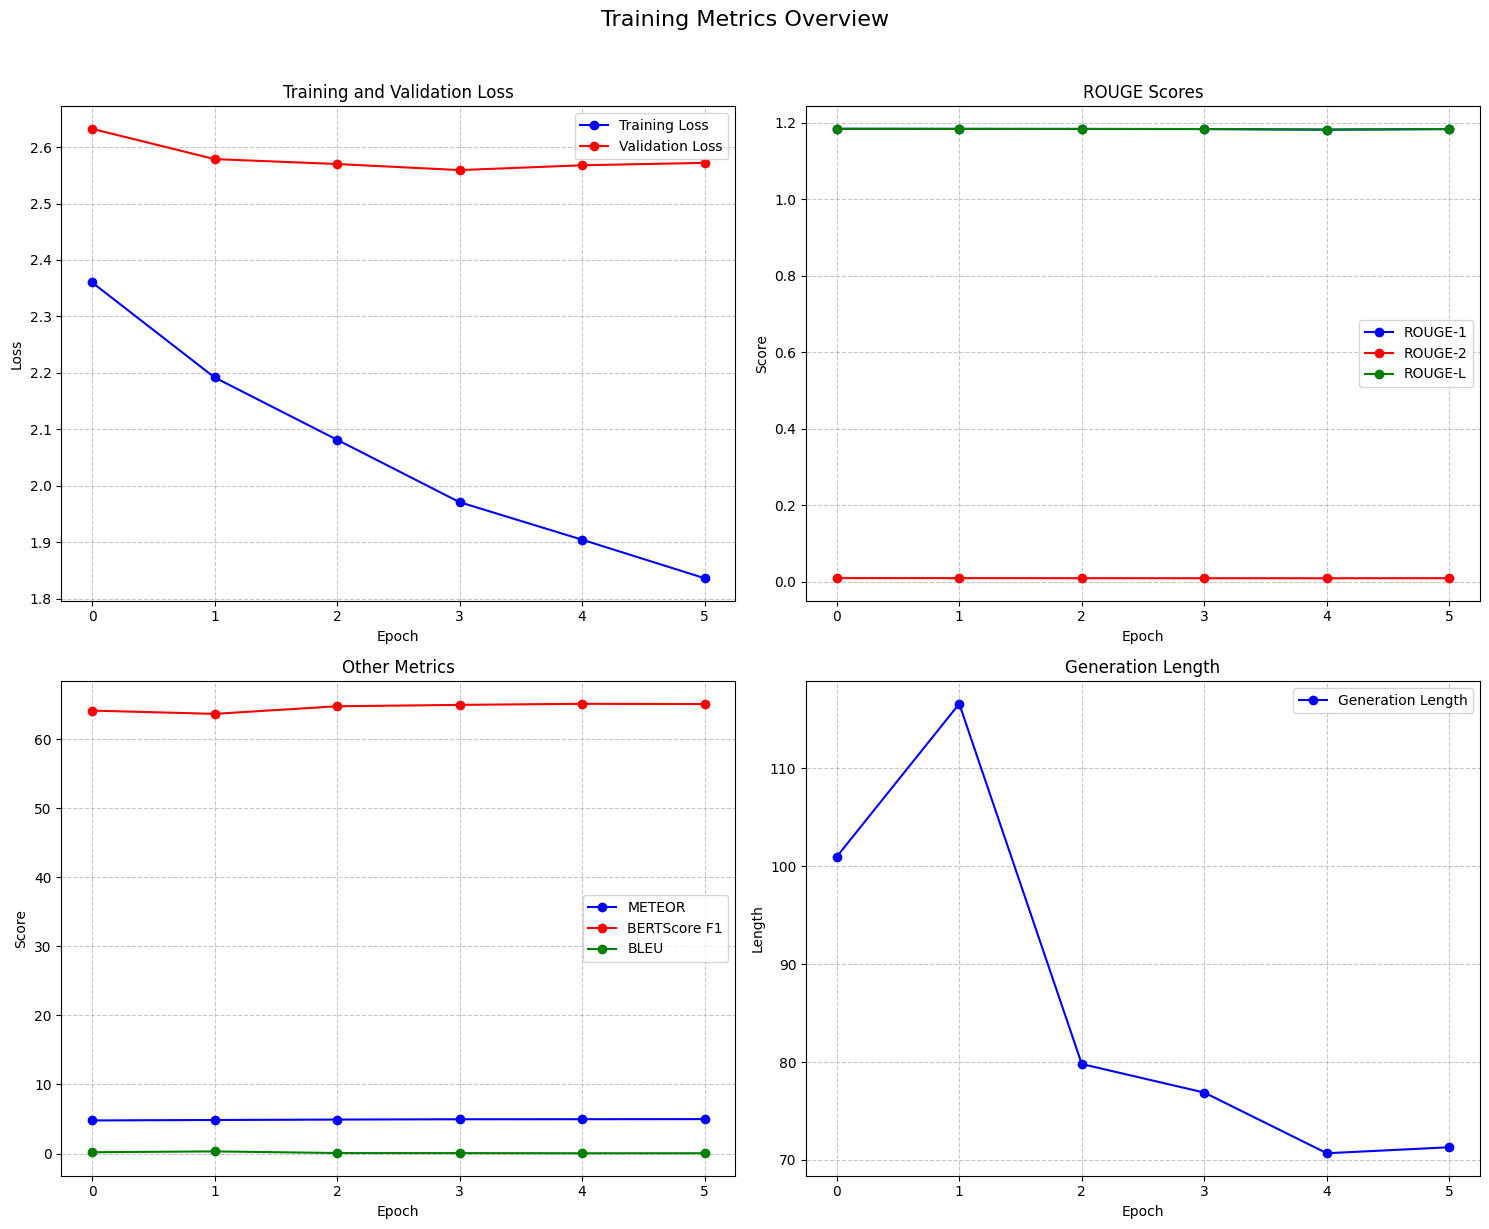


Final Metrics:
Train Loss: 1.8359
Validation Loss: 2.5721
ROUGE-1: 1.1829
ROUGE-2: 0.0095
ROUGE-L: 1.1829
METEOR: 4.9785
BERTScore: 65.0670
BLEU: 0.0395
Generation Length: 71.3010


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# nan 값을 제외하고 데이터 추출
train_loss = history_df['Training Loss'].dropna().values
eval_loss = history_df['Validation Loss'].dropna().values
rouge1 = history_df['Rouge1'].dropna().values
rouge2 = history_df['Rouge2'].dropna().values
rougeL = history_df['Rougel'].dropna().values
meteor = history_df['Meteor'].dropna().values
bertscore = history_df['Bertscore F1'].dropna().values
bleu = history_df['Bleu'].dropna().values
gen_len = history_df['Gen Len'].dropna().values

# 실제 데이터 개수에 맞춰 epochs 배열 생성
epochs = np.arange(len(eval_loss))

# 그래프 생성
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training Metrics Overview', fontsize=16, y=1.02)

# Loss plot
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', marker='o')
ax1.plot(epochs, eval_loss, 'r-', label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# ROUGE scores over time
ax2.plot(epochs, rouge1, 'b-', label='ROUGE-1', marker='o')
ax2.plot(epochs, rouge2, 'r-', label='ROUGE-2', marker='o')
ax2.plot(epochs, rougeL, 'g-', label='ROUGE-L', marker='o')
ax2.set_title('ROUGE Scores')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Other metrics
ax3.plot(epochs, meteor, 'b-', label='METEOR', marker='o')
ax3.plot(epochs, bertscore, 'r-', label='BERTScore F1', marker='o')
ax3.plot(epochs, bleu, 'g-', label='BLEU', marker='o')
ax3.set_title('Other Metrics')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Generation length
ax4.plot(epochs, gen_len, 'b-', label='Generation Length', marker='o')
ax4.set_title('Generation Length')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Length')
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# 그래프 저장
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 결과값들 출력
print("\nFinal Metrics:")
print(f"Train Loss: {train_loss[-1]:.4f}")
print(f"Validation Loss: {eval_loss[-1]:.4f}")
print(f"ROUGE-1: {rouge1[-1]:.4f}")
print(f"ROUGE-2: {rouge2[-1]:.4f}")
print(f"ROUGE-L: {rougeL[-1]:.4f}")
print(f"METEOR: {meteor[-1]:.4f}")
print(f"BERTScore: {bertscore[-1]:.4f}")
print(f"BLEU: {bleu[-1]:.4f}")
print(f"Generation Length: {gen_len[-1]:.4f}")